In [130]:
# Import libs
import sys
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from docplex.util.environment import get_environment
from docplex.mp.relax_linear import LinearRelaxer
import matplotlib.patches as mpatches
import numpy as np

try:
    import docplex.mp
except:
    raise Exception('Please install docplex. See https://pypi.org/project/docplex/')

In [131]:
#Servicios
A = "Ensobrado"
B = "Etiquetado"
servicios = [A, B]
LIMITES_PRODUCCION = {
    A: 500_000,
    B: 700_000,
}

PRECIO_VENTA = {
    A: 3.20,
    B: 1.28,
}

PRECIO_CAJAS = 15
CAPACIDAD_CAJA = {
    A: 300,
    B: 450
} # Cantidad que entra por cada caja que compro del producto

# Maquina
LIMITE_HORAS_MAQUINA = 48
PRODUCCION_MAQUINA = 5_000 # Cantidad que puede doblar en una hora

# Horas hombre
PERSONAL = 13
DIAS_LABORABLES = 24
HORAS_BASE = 8
LIMITE_HORAS_HOMBRE = HORAS_BASE*DIAS_LABORABLES*PERSONAL
PRODUCCION_HORA = {
    A: 600,
    B: 800
}
PRECIO_HORA_EXTRA = 50
PRECIO_CAPACIDAD_OCIOSA = 150

# Translado
PRECIO_TRANSLADO = 10_000
CAPACIDAD_TRANSLADO = 7_000

In [ ]:
mdl1 = Model(name="TP: Equipo A SRL")

producido = dict()
cantidad_cajas = dict()
for servicio in servicios:
    producido[servicio] = mdl1.continuous_var(name=f'Producido_{servicio}')
    cantidad_cajas[servicio] = mdl1.continuous_var(name=f"Cantidad_Cajas_A_Comprar_Para_{servicio}")
horas_maquina = mdl1.continuous_var(name=f"Consumo_horas_maquina")
horas_produccion = mdl1.continuous_var(name=f"Consumo_horas_produccion")
horas_extra = mdl1.continuous_var(name=f"Horas_Extra")
capacidad_ociosa = mdl1.continuous_var(name=f"Horas_Sobrantes")
cantidad_translados = mdl1.continuous_var(name=f"Cantidad_Translados")

#-- Restricciones --
#-- Demanda máxima --
for servicio in servicios:
    mdl1.add_constraint(producido[servicio] <= LIMITES_PRODUCCION[servicio])

#-- Consumo recursos --
# Consumo de cajas
for servicio in servicios:
    mdl1.add_constraint(CAPACIDAD_CAJA[servicio]*cantidad_cajas[servicio] == producido[servicio])
# Consumo de maquina
mdl1.add_constraint(PRODUCCION_MAQUINA*horas_maquina == producido[A]) # Solo el producto A tiene un proceso de maquina
mdl1.add_constraint(horas_maquina <= LIMITE_HORAS_MAQUINA)
# Consumo horas trabajo
for servicio in servicios:
    mdl1.add_constraint(PRODUCCION_HORA[servicio]*horas_produccion == producido[servicio])
# Translado
mdl1.add_constraint(CAPACIDAD_TRANSLADO*cantidad_translados == producido[A])

#-- Restricciones horarias --
PERSONAL_NECESARIO_MAQUINA = 2
mdl1.add_constraint(PERSONAL_NECESARIO_MAQUINA*horas_maquina + horas_produccion == LIMITE_HORAS_HOMBRE + horas_extra - capacidad_ociosa)

ingresos = mdl1.sum(PRECIO_VENTA[servicio]*producido[servicio] for servicio in servicios)
costos_materia_prima = mdl1.sum(PRECIO_CAJAS*cantidad_cajas[servicio] for servicio in servicios)
costo_horas_extra = horas_extra*PRECIO_HORA_EXTRA
costo_capacidad_ociosa = capacidad_ociosa*PRECIO_CAPACIDAD_OCIOSA
costo_translado = cantidad_translados*PRECIO_TRANSLADO

costos = costos_materia_prima + costo_horas_extra + costo_capacidad_ociosa + costo_translado

beneficio = ingresos - costos
mdl1.maximize(beneficio)

solution = mdl1.solve()
# --- Imprimir información ---
mdl1.print_information()

Model: TP: Equipo A SRL
 - number of variables: 9
   - binary=0, integer=0, continuous=9
 - number of constraints: 10
   - linear=10
 - parameters: defaults
 - objective: maximize
 - problem type is: LP


In [133]:
# Imprimir la solución
if solution:
    print(f'BENEFICIO:')
    print(f' - ${mdl1.objective_value:.2f}')
    
else:
    print("No se encontro solución.")

BENEFICIO:
 - $504876.19


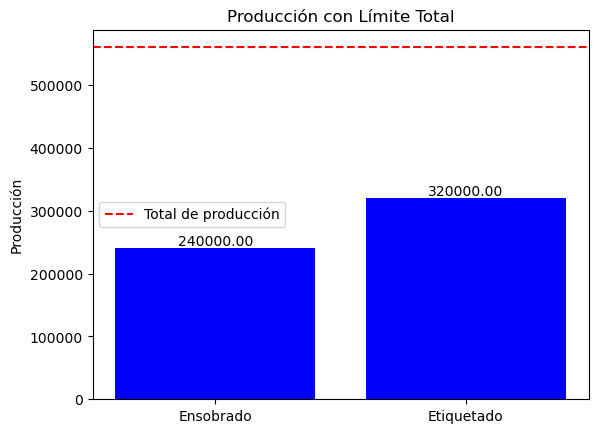

In [134]:
# Datos necesarios
produccion_graf = {servicio: producido[servicio].solution_value for servicio in servicios}
total = sum(produccion_graf.values())

fig, ax = plt.subplots()
bars = ax.bar(produccion_graf.keys(), produccion_graf.values(), color='blue')
ax.axhline(y=total, color='r', linestyle='--', label='Total de producción')
ax.set_ylabel('Producción')
ax.set_title('Producción con Límite Total')
ax.legend()

# Mostrar el valor sobre cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

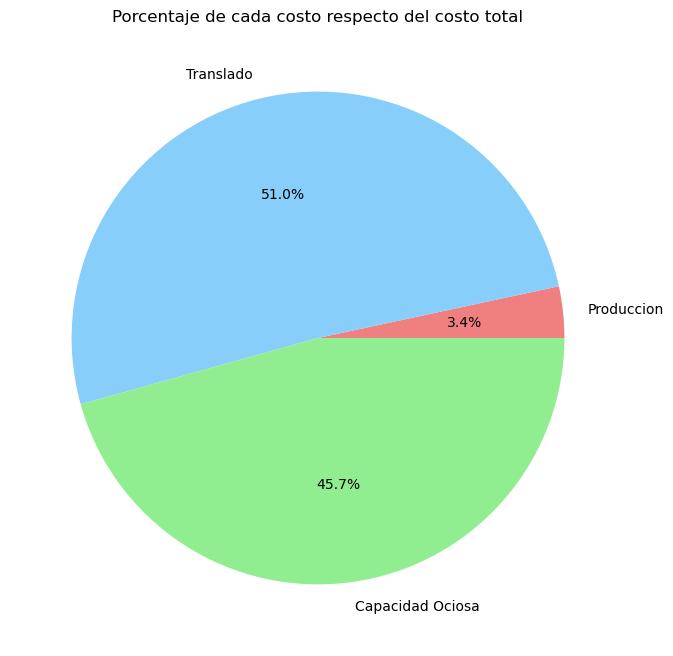

In [135]:
# Datos necesarios
costos = {
    "Produccion" : costos_materia_prima.solution_value,
    "Translado" : costo_translado.solution_value,
    "Horas Extra" : costo_horas_extra.solution_value,
    "Capacidad Ociosa": costo_capacidad_ociosa.solution_value
}
total = sum(costos.values())
porcentaje_costos = {tipo: (valor / total) * 100 for tipo, valor in costos.items() if valor > 0}

# Gráfico de pastel para representar el porcentaje de cada aceite en el producto final
plt.figure(figsize=(8, 8))
plt.pie(porcentaje_costos.values(), labels=porcentaje_costos.keys(), autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'lightpink'])
plt.title('Porcentaje de cada costo respecto del costo total')
plt.show()